Appendix

Python Implementation

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(img):
    return plt.imshow(img,cmap="gray")

def img_adj(img,a = 3,b=-550):
    return cv.convertScaleAbs(img, alpha=a, beta=b)  

def binarize(img,threshold=128):
    _,thresh = cv.threshold(img,threshold,256,cv.THRESH_BINARY)
    return thresh

def create_blank(img):
    return np.zeros(img.shape,dtype = np.uint8)

def get_contour(img):
    contours,_= cv.findContours(img,cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    return(contours)

def get_thresh(img):    
    hist = cv.calcHist([img],[0],None,[256],[0,256])
    n,x = 0,0

    for i in range(len(hist)):
        if(hist[i]):
            x += i
            n += 1
    return(int(x/n))

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename),cv.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

def detect_bead(img,iteration):    
    contours = get_contour(img)
    
    for i in range(iteration):
        pos = []    
        b = create_blank(img)
        
        for contour in contours:    
            (x,y),rad = cv.minEnclosingCircle(contour)
            x,y,rad = int(x),int(y),int(rad)
            pos.append((x,y,rad))
            cv.circle(b, (x,y), rad, (57, 255, 20), -1)    
    
        blur = cv.medianBlur(b,17)
        contours = get_contour(blur)
    return(b,pos)

def draw_circles(ini,fin,ps,save):
    p_imgs = []
    
    if(save):dims = find_strip_dim(p_pos)
    
    for i in range(ini,fin):
        t =  cv.merge([imgs[i],imgs[i],imgs[i]]) 
        blank = create_blank(t)

        for j in range(len(ps[i])):
            cv.circle(blank, (ps[i][j][0],ps[i][j][1]), ps[i][j][2]+15, (57, 255, 20), 10)
            
            if(ini+1==fin):
                blank = cv.putText(blank, f"{j}", (ps[i][j][0],ps[i][j][1]-ps[i][j][2]-70), cv.FONT_HERSHEY_SIMPLEX,2.5, (0,255,0), 5, cv.LINE_AA)
        
        p_imgs.append(cv.bitwise_or(blank,t))
        
        if(save):
            cv.imwrite(op_des+f"/Center is {i,(ps[i][j][0],ps[i][j][1])}.png",p_imgs[i][dims[0]:dims[1],dims[2]:dims[3],:])
        
    return (p_imgs)

def show_highlight(fr,ps,save=False):    
    if fr == n:
        return(draw_circles(0,n,ps,save))
    else:
        return(draw_circles(fr,fr+1,ps,save)[0])

def find_strip_dim(ps):
    x_max,y_max = ps[0][0][0],ps[0][0][1]
    x_min,y_min = ps[0][0][0],ps[0][0][1]
    r = 0
    for i in range(n):
        for j in range(len(ps[i])):
            x_max,y_max = max(x_max,ps[i][j][0]),max(y_max,ps[i][j][1])
            x_min,y_min = min(x_min,ps[i][j][0]),min(y_min,ps[i][j][1]) 
            r = max(ps[i][j][2],r)
    return(y_min-3*r,y_max+3*r,x_min-3*r,x_max+3*r)

In [3]:
def process_img(img,bg):
    diff = cv.absdiff(img, bg)
    blur = cv.medianBlur(diff,17)
    adjested_img = img_adj(blur,5,0)
    
    threshold = get_thresh(adjested_img)
    
    threshed_img = binarize(adjested_img,threshold)
    dilated_img = cv.dilate(threshed_img, None, iterations=2)
    
    return(detect_bead(dilated_img,3))


In [4]:
# Loading Images from a Folder

# C:\Users\neutr\Desktop\Mini Project\Training Set 2\set2
op_des = "./Procced Img/set2"
ip_des = "./Training Set 2/set2/"
imgs = load_images_from_folder(ip_des)
n = len(imgs)

mean_background = np.median(imgs, axis=0).astype(np.uint8)

In [5]:
# Calculating Center Coordinates of all moving objects
pos = []

for i in range(n):
    img,temp = process_img(imgs[i],mean_background)
    pos.append(temp)


Max Number of Moving Object = 4 and Minimum Number of Moving Object is = 2


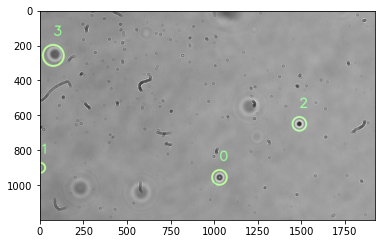

In [6]:
# Calculating Maximun,Minimum and total number of moving objects 
nop = [len(i) for i in pos]
ma = max(nop)
mi = min(nop) 
mfn = 0

print(f"Max Number of Moving Object = {ma} and Minimum Number of Moving Object is = {mi}")

# Finding the Frame where there is maximum number of moving objects
for i in range(len(nop)):
    if nop[i]==ma:
        mfn = i
        break
        
# Showing the Maximum Number of Moving Object Detected by the Program
show(show_highlight(mfn,pos))

In [7]:
# Selecting one object and storing its coordinates
ob = 0
tol = 100
ob_pos = pos[mfn][ob]
p_pos = []
lp = 0

for i in range(mfn,-1,-1):    
    for j in range(len(pos[i])):
        if( abs(pos[i][j][0]-ob_pos[0]) < tol and abs(pos[i][j][1]-ob_pos[1]) < tol):

            p_pos.insert(0,[pos[i][j]])
            ob_pos = pos[i][j]
            break

    if lp == len(p_pos):
        p_pos.insert(0,[(0,0,1)])
        lp = len(p_pos)
    else:lp = len(p_pos)    

    
ob_pos = pos[mfn][ob]
for i in range(mfn+1,n):
    for j in range(len(pos[i])):

        if( abs(pos[i][j][0]-ob_pos[0]) < tol and abs(pos[i][j][1]-ob_pos[1]) < tol ):
            p_pos.append([pos[i][j]])
            ob_pos = pos[i][j]
            break
        
    if lp == len(p_pos):
        p_pos.append([(0,0,1)])
        lp = len(p_pos)
    else:lp = len(p_pos)



In [9]:
# Getting highlighted Images of the object and Saving them
p_imgs = show_highlight(n,p_pos,True)
